# Preventing Bad Loans with Machine Learning: An Exercise in Binary Classification and Feature Engineering in the Banking Industry
## Leveraging Neural Networks to Predict Loan Outcomes
### Pablo X Zumba

The data set for this exercise is from the banking industry. It contains data about the home loans of 2,500 bank clients. Each row represents a single loan. The columns include the characteristics of the client who used a loan. This is a binary classification task: predict whether a loan will be bad or not (1=Yes, 0=No). This is an important task for banks to prevent bad loans from being issued.

## Description of Variables

The description of variables are provided in "Loan - Data Dictionary.docx"

## Goal

Use the **loan.csv** data set and build a model to predict **BAD**. 



# Read and Prepare the Data

In [1]:
# Common imports

import pandas as pd
import numpy as np

np.random.seed(42)

# Get the data

In [2]:
#We will predict the "price" value in the data set:

loan = pd.read_csv("loan.csv")
loan.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,25900,61064.0,94714.0,DebtCon,Office,2.0,0.0,0.0,98.809375,0.0,23.0,34.565944
1,0,26100,113266.0,182082.0,DebtCon,Sales,18.0,0.0,0.0,304.852469,1.0,31.0,33.193949
2,1,50000,220528.0,300900.0,HomeImp,Self,5.0,0.0,0.0,0.000000,0.0,2.0,NaN
3,1,22400,51470.0,68139.0,DebtCon,Mgr,9.0,0.0,0.0,31.168696,2.0,8.0,37.952180
4,0,20900,62615.0,87904.0,DebtCon,Office,5.0,NaN,NaN,177.864849,NaN,15.0,36.831076


# Split data (train/test)

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(loan, test_size=0.3)

# Data Prep

Perform your data prep here. You can use pipelines like we do in the tutorials. Otherwise, feel free to use your own data prep steps. Eventually, you should do the following at a minimum:<br>
- Separate inputs from target<br>
- Impute/remove missing values<br>
- Standardize the continuous variables<br>
- One-hot encode categorical variables<br>

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

## Separate the target variable 

In [5]:
train_target = train['BAD']
test_target = test['BAD']

train_inputs = train.drop(['BAD'], axis=1)
test_inputs = test.drop(['BAD'], axis=1)

## Feature Engineering: Derive a new column

Examples:
- Ratio of delinquent to total number of credit lines
- Ratio of loan to value of current property
- Convert yr_renovated to a binary variable (i.e., renovated or not)
- (etc.)

Creating a new categorical column related to "Number of credit lines" LOAN:

In [6]:
# Let's analyze "minimum_nights"

train_inputs['LOAN'].describe()

count     1750.000000
mean     18142.457143
std      11280.619735
min       1100.000000
25%      10600.000000
50%      15700.000000
75%      23075.000000
max      89000.000000
Name: LOAN, dtype: float64

In [7]:
train_inputs['LOAN'].value_counts()

15000    43
10000    36
20000    27
25000    26
12000    23
         ..
40600     1
45100     1
33300     1
52900     1
2800      1
Name: LOAN, Length: 402, dtype: int64

<AxesSubplot: >

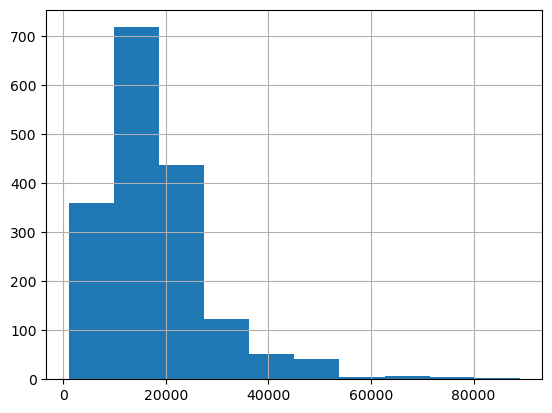

In [8]:
train_inputs['LOAN'].hist()

##### Since the histogram does not appear much skewed, a conversion of the number of credit lines will be performed into categorical values.

In [9]:
# qcut creates n quantiles (it is a discretization technique)
# Let's create 5 quantiles:
pd.qcut(train_inputs['LOAN'], 5, duplicates='drop')   

# Notice, it can't do 5 quantiles because of the overlapping edges. It can only 3.

1552    (13900.0, 18300.0]
2290    (18300.0, 25000.0]
1398    (1099.999, 9600.0]
1775    (25000.0, 89000.0]
2299     (9600.0, 13900.0]
               ...        
1638    (1099.999, 9600.0]
1095    (13900.0, 18300.0]
1130    (13900.0, 18300.0]
1294     (9600.0, 13900.0]
860     (13900.0, 18300.0]
Name: LOAN, Length: 1750, dtype: category
Categories (5, interval[float64, right]): [(1099.999, 9600.0] < (9600.0, 13900.0] < (13900.0, 18300.0] < (18300.0, 25000.0] < (25000.0, 89000.0]]

In [10]:
pd.qcut(train_inputs['LOAN'],5, duplicates='drop',
        labels=['low','few', 'medium','high', 'too_much']).value_counts()

high        359
few         353
low         351
medium      349
too_much    338
Name: LOAN, dtype: int64

In [11]:
def new_col(df):
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()
    
    df1['LOAN_cat'] = pd.qcut(df1['LOAN'],5, duplicates='drop',
                        labels=['low','few', 'medium','high', 'too_much'])
    

    return df1[['LOAN_cat']]
    # You can use this to check whether the calculation is made correctly:
    return df1

##  Identify the numeric, binary, and categorical columns

In [12]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [13]:
numeric_columns

['LOAN',
 'MORTDUE',
 'VALUE',
 'YOJ',
 'DEROG',
 'DELINQ',
 'CLAGE',
 'NINQ',
 'CLNO',
 'DEBTINC']

In [14]:
categorical_columns

['REASON', 'JOB']

In [15]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = []

In [16]:
# Be careful: numerical columns already includes the binary columns,
# So, we need to remove the binary columns from numerical columns.

for col in binary_columns:
    numeric_columns.remove(col)

In [17]:
# define your feature engineered column(s) here
feat_eng_columns = ['LOAN']

# Pipeline

In [18]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [19]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [20]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [21]:
# Create a pipeline for the transformed column here
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col)),
                               ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
                               ('onehot', OneHotEncoder(handle_unknown='ignore'))])



In [22]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('trans', my_new_column, feat_eng_columns)],   
        remainder='passthrough')

#passtrough is an optional step. You don't have to use it.

# Transform: fit_transform() for TRAIN

In [23]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

array([[-0.31412013, -1.30301181, -0.86148829, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.45733454,  0.7398414 ,  0.58636192, ...,  0.        ,
         0.        ,  0.        ],
       [-1.10330939,  0.2001631 ,  0.18146318, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.21657988, -0.83000156, -0.82081329, ...,  0.        ,
         1.        ,  0.        ],
       [-0.46486414,  1.79196675,  1.36974799, ...,  0.        ,
         0.        ,  0.        ],
       [-0.31412013, -0.08740643, -0.21782887, ...,  0.        ,
         1.        ,  0.        ]])

In [24]:
train_x.shape

(1750, 25)

# Tranform: transform() for TEST

In [25]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

array([[ 0.06717356,  0.36706438,  0.32127798, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.32432512,  0.57631513,  0.42769944, ...,  0.        ,
         0.        ,  0.        ],
       [-0.33185472,  0.41209537,  0.12227549, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.8993616 , -0.51071616, -0.32326299, ...,  1.        ,
         0.        ,  0.        ],
       [-0.5446698 , -0.82706576, -0.8366813 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.5446698 , -0.06422056, -0.11380525, ...,  0.        ,
         0.        ,  0.        ]])

In [26]:
test_x.shape

(750, 25)

# Calculate the Baseline

In [27]:
# Sci-kit Learn's DummyClassifier automates the entire process performed manually above.
# First, you instantiate it with the "most_frequent" strategy. 
# Then, you fit the model. This finds the most frequently (i.e., majority) class (in the training set).

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(train_x, train_target)

DummyClassifier(strategy='most_frequent')

In [28]:
from sklearn.metrics import accuracy_score

In [29]:
# Then, you call the predict function of the classifier.
# This predicts all values as the majority class.
# In the next step, you compare the predicted values with the actual values to calculate accuracy
# This is the baseline Train Accuracy

dummy_train_pred = dummy_clf.predict(train_x)

baseline_train_acc = accuracy_score(train_target, dummy_train_pred)

print('Baseline Train Accuracy: {}' .format(baseline_train_acc))

Baseline Train Accuracy: 0.6034285714285714


In [30]:
# We repeat the same steps for the test set
# This is the baseline Test Accuracy

dummy_test_pred = dummy_clf.predict(test_x)

baseline_test_acc = accuracy_score(test_target, dummy_test_pred)

print('Baseline Test Accuracy: {}' .format(baseline_test_acc))

Baseline Test Accuracy: 0.5773333333333334


# Train a shallow (one-layer) NN model

In [31]:
from sklearn.neural_network import MLPClassifier

#Default settings create 1 hidden layer with 100 neurons
mlp_clf = MLPClassifier(hidden_layer_sizes=(50,))

mlp_clf.fit(train_x, train_target)

/Users/pablozumba/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(50,))

### Calculate the accuracy

In [32]:

from sklearn.metrics import accuracy_score


In [33]:
#Predict the train values
train_y_pred = mlp_clf.predict(train_x)

#Train accuracy
accuracy_score(train_target, train_y_pred)

0.8805714285714286

In [34]:
#Predict the test values
test_y_pred = mlp_clf.predict(test_x)

#Test accuracy
accuracy_score(test_target, test_y_pred)

0.7893333333333333

# Train a deep (multi-layered) NN model 

In [35]:

dnn_clf = MLPClassifier(hidden_layer_sizes=(90,60,30),
                       max_iter=100)

dnn_clf.fit(train_x, train_target)

/Users/pablozumba/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(90, 60, 30), max_iter=100)

In [36]:
#Let's check the number of iterations:
dnn_clf.n_iter_

100

In [37]:
#Let's check the number of layers:
dnn_clf.n_layers_

5

### Calculate the accuracy

In [38]:
#Predict the train values
train_y_pred = dnn_clf.predict(train_x)

#Train accuracy
accuracy_score(train_target, train_y_pred)

1.0

In [39]:
#Predict the test values
test_y_pred = dnn_clf.predict(test_x)

#Test accuracy
accuracy_score(test_target, test_y_pred)

0.8453333333333334